# __Project Description__

The following is an analysis of a toy dataset provided as part of a data science skills assessment.  The dataset comprises a set of observations of 8 continuous feature variables.  The task is to describe the dataset, visualize the dataset, determine whether the dataset is the union of multiple sources, and if so, assign each observation to the correct source.

In [1]:
%matplotlib inline
import importlib
from IPython.display import display, HTML, Image
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from matplotlib.ticker import FuncFormatter
import matplotlib.font_manager
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from scipy import stats
import lmfit.models as mdls
import statsmodels.api as sm
from itertools import product
import warnings
import pdb

warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '{0:4f}'.format(x))

np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

#display(HTML(data="""
#<style>
#    div#notebook-container { width: 1850px; }
#</style>
#"""))

/Users/mgerstein/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def get_hists(df, measure_columns, min_max_pctiles, func, ncols=4, fontsize=12, figsize=(20,20)):
    if int(len(measure_columns) / ncols) != len(measure_columns) / float(ncols):
        nrows = int(len(measure_columns) / ncols) + 1
    else:
        nrows = int(len(measure_columns) / ncols)

    places = list(product(range(nrows), range(ncols)))
    idx = 0

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,)
    fig.set_size_inches(figsize)

    for i, col in enumerate(measure_columns):
        min_pctile = min_max_pctiles[col][0]
        max_pctile = min_max_pctiles[col][1]
 
        if nrows == 1 and ncols == 1:
            my_ax = ax
        elif nrows == 1 or ncols == 1:
            my_ax = ax[idx]
        else:
            my_ax = ax[places[idx][0]][places[idx][1]]

        if func == 'log':
            sns.distplot(np.log(df[(np.log(df[col]+1) >= np.log(df[col]+1).quantile(min_pctile)) & \
                                   (np.log(df[col]+1) <= np.log(df[col]+1).quantile(max_pctile))][col]+1), kde=True, ax=my_ax)
        elif func == 'sqrt':
            sns.distplot(np.sqrt(df[(np.sqrt(df[col]) >= np.sqrt(df[col]).quantile(min_pctile)) & \
                                    (np.sqrt(df[col]) <= np.sqrt(df[col]).quantile(max_pctile))][col]+1), kde=True, ax=my_ax)
        else:
            sns.distplot(df[(df[col] >= df[col].quantile(min_pctile)) & (df[col] <= df[col].quantile(max_pctile))][col], kde=True, ax=my_ax)

        new_x_label = my_ax.get_xlabel()
        
        my_ax.set_xlabel(new_x_label, fontdict={'fontweight': 'bold', 'fontsize': fontsize})
        my_ax.set_xticklabels(my_ax.get_xticklabels(), fontdict={'fontweight': 'bold', 'fontsize': fontsize})
        my_ax.set_yticklabels(my_ax.get_yticklabels(), fontdict={'fontweight': 'bold', 'fontsize': fontsize})
        
        if func == 'log':
            if np.log(df[col]+1).quantile(max_pctile) >= 10:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
            else:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.2f}'.format(x)))
        elif func == 'sqrt':
            if np.sqrt(df[col]).quantile(max_pctile) >= 10:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
            else:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.2f}'.format(x)))
        else:
            if df[col].quantile(max_pctile) >= 10:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
            else:
                my_ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: '{0:.2f}'.format(x)))
               
        #my_ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

        idx += 1

    plt.tight_layout()
    plt.show()

In [3]:
df = pd.read_csv('/Users/mgerstein/shared/mag/portfolio/data_set_2.csv')

In [4]:
feature_x = ['x1', 'x2', 'x3', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']
random_state = 17

The dataset contains 2,000 observations of 8 continuous variables. There is no missing data, no obvious outliers or anomalous values, and values are both positive and negative for all variables. The data is unlabeled and appears to be comprised of feature variables.

The first visualization of the dataset is a pair plot grid. This provides both the distribution of each feature variable as well as plots the pairwise relationships.  All of the feature variables are multimodal except for x2, x4, and x5.  In addition, some of the pairwise plots show multiple groupings indicating a likelihood that there are multiple sources for the data.  The next visualization is a correlation heatmap. This might give some indication as to the nature of any relationships uncovered in the pair plots as well as indicate whether some type of dimensionality reduction could be applied.  There is a high level of both positive and negative correlation between many of the variables.  This suggests that there is an opportunity to reduce the data into its principal components.  

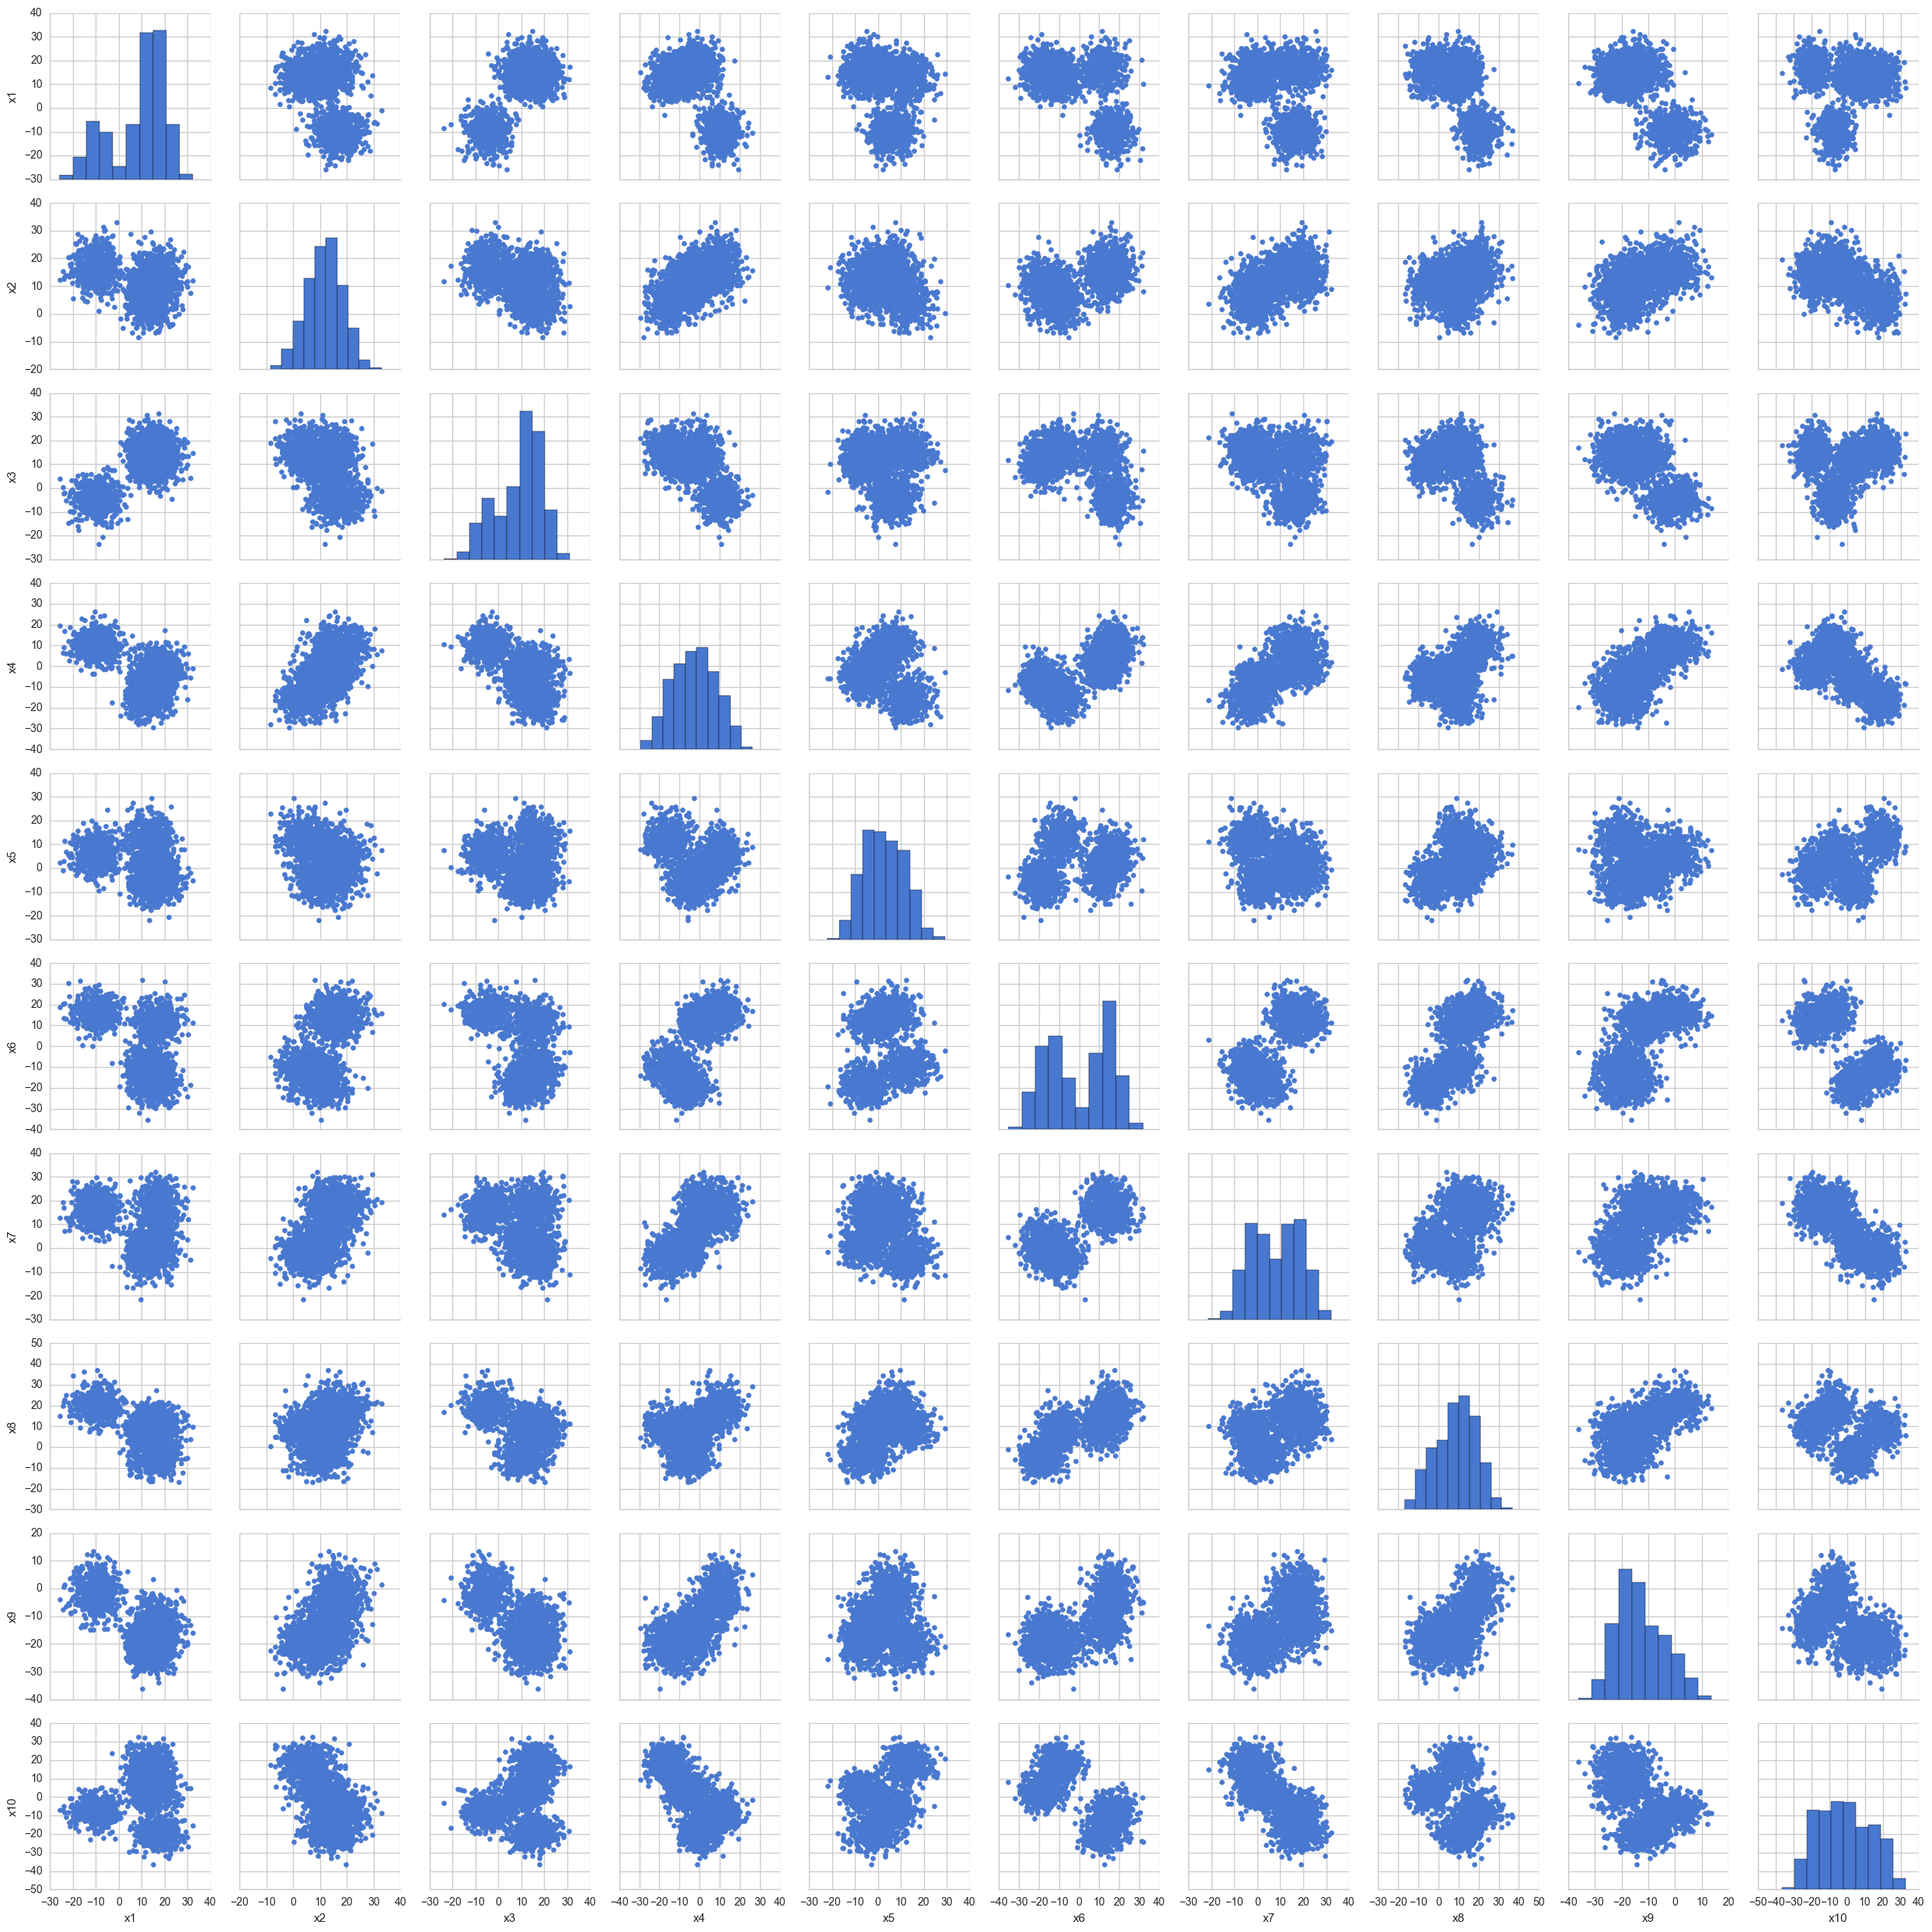

In [5]:
g = sns.PairGrid(df)
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

#for i, j in zip(*np.triu_indices_from(g.axes, 1)):
#    g.axes[i, j].set_visible(False)

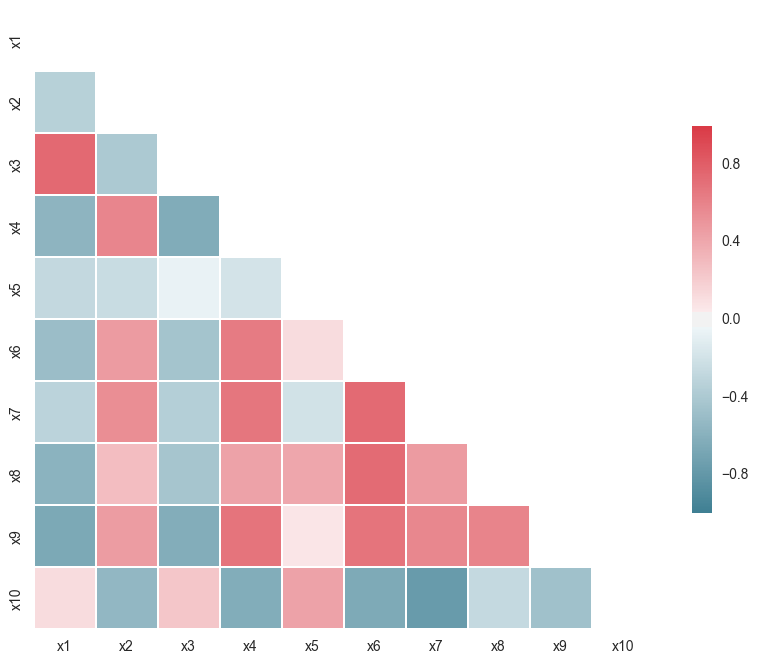

In [6]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Here is a closer look at the distributions of each of the feature variables in order to get a more detailed look at modes and outliers.  Below the visualization are quantiles, mean and standard deviation of each of the feature variables.  This serves to confirm the conclusions generated from looking at the distribution histograms. 

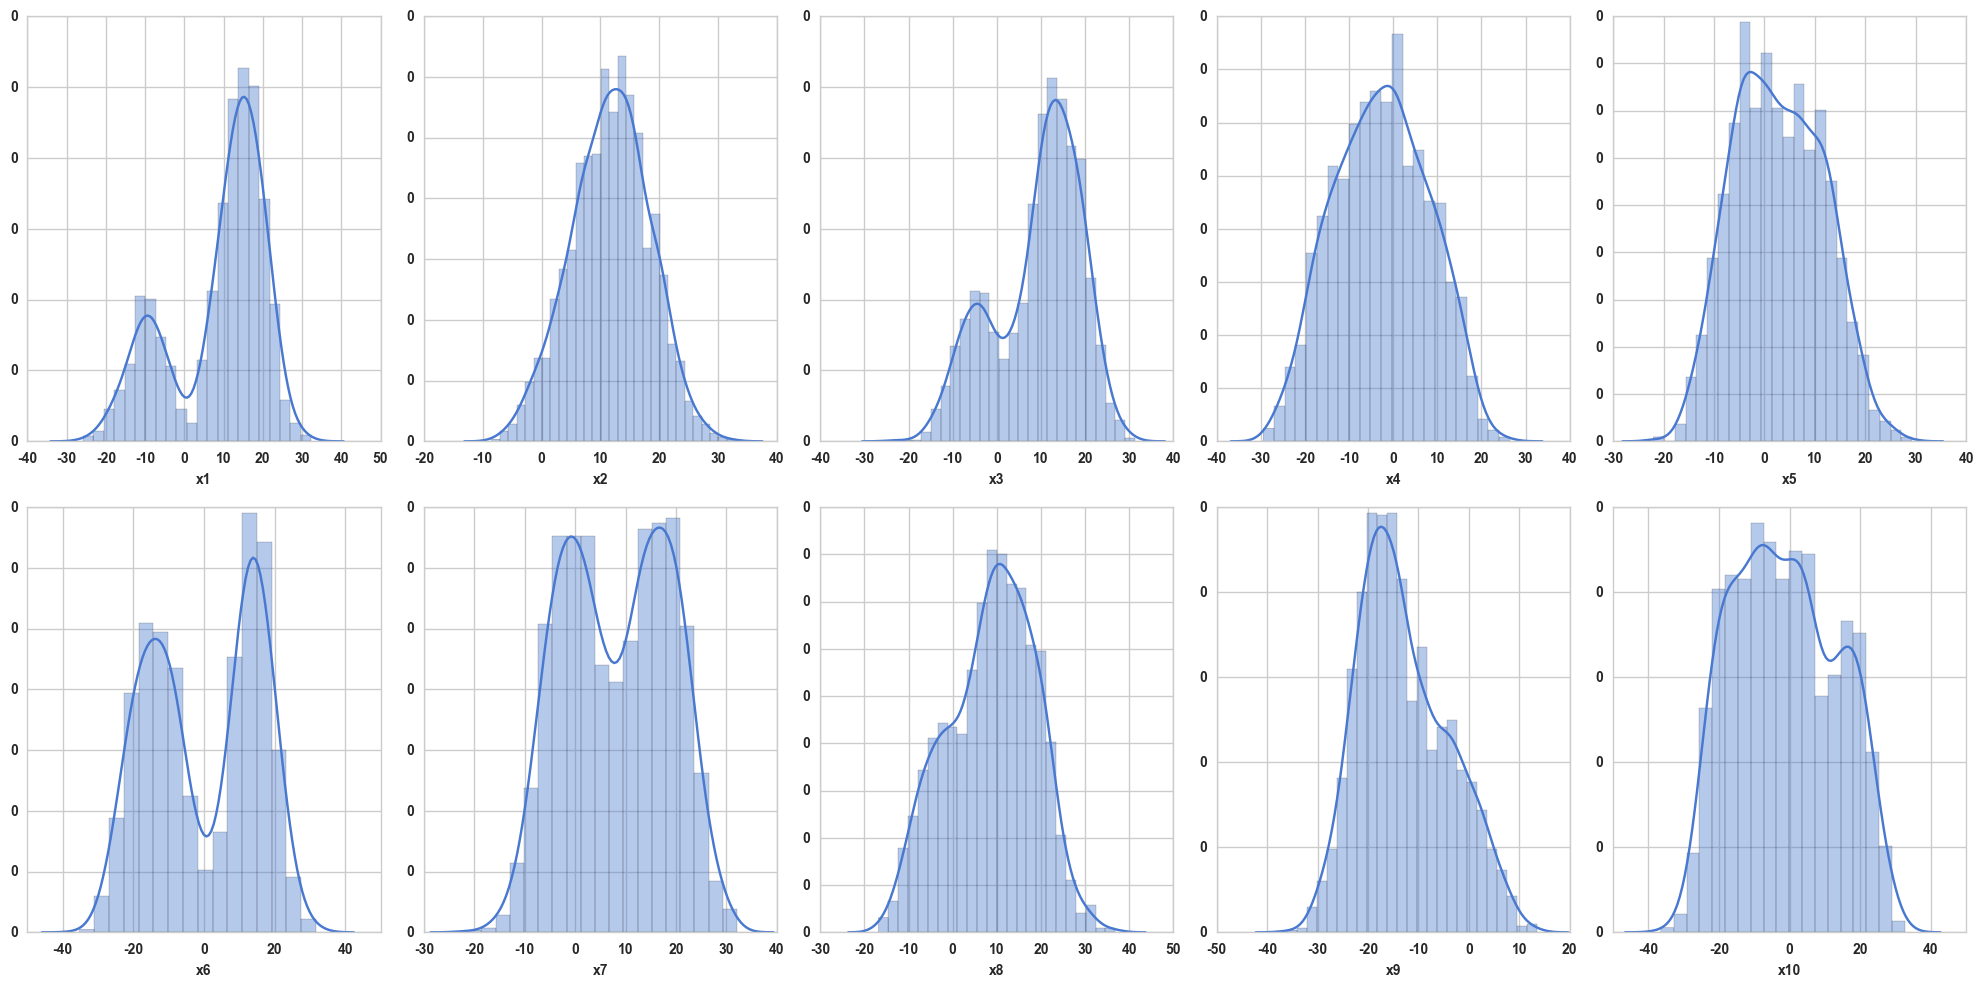

In [7]:
min_max_pctiles = {
    'x1': (0.00, 1.00), 
    'x2': (0.00, 1.00), 
    'x3': (0.00, 1.00), 
    'x4': (0.00, 1.00), 
    'x5': (0.00, 1.00), 
    'x6': (0.00, 1.00), 
    'x7': (0.00, 1.00), 
    'x8': (0.00, 1.00), 
    'x9': (0.00, 1.00),
    'x10': (0.00, 1.00),
}

get_hists(df, df.columns, min_max_pctiles, func='', ncols=5, fontsize=10, figsize=(20,10))

In [8]:
pctiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
df.describe(pctiles)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,8.677829,11.716801,9.252817,-2.679634,2.774942,0.077631,8.200884,8.712878,-12.860135,-1.339360
std,11.971827,6.655333,9.861443,10.625164,8.800553,15.375478,10.426023,9.881482,8.881026,14.534143
min,-25.824199,-8.497562,-23.666439,-29.429655,-22.033329,-35.264019,-21.428538,-16.811146,-36.065150,-36.468083
1%,-19.398512,-3.731049,-13.523720,-24.925860,-14.859247,-27.134252,-11.741860,-12.521553,-29.355643,-27.693216
5%,-13.960712,0.201969,-8.925702,-19.716462,-10.875581,-22.791553,-7.615489,-8.288963,-25.455445,-23.170703
10%,-10.740787,2.896500,-6.069523,-17.031772,-8.541304,-20.233174,-5.451634,-5.429906,-23.296117,-20.467317
25%,0.231327,7.161564,2.648845,-10.652694,-4.098043,-14.003670,-0.812888,1.480706,-19.430697,-13.216190
50%,12.754335,11.896021,11.422441,-2.631318,2.484416,1.500838,8.532535,9.628064,-14.417786,-2.094310
75%,17.364337,16.279210,16.503676,5.340314,9.660898,14.050512,17.138898,16.081044,-6.534142,10.561797


As indicated above, high levels of correlation among the feature variables along with multimodal distribution indicate multple sources for the data.  A principal component analysis shows that the variance in the dataset can be sufficiently explained by 2 to 4 components in lieu of all 8.  Plotting the first two principal components will show if and how the dataset separates.  Essentially, an optimal stretch and rotation in the original 8-dimensional space that allows the presentation of the data in 2 dimensions in an unsupervised manner.  The 2D plot shows that the dataset has 4 sources that can be uniquely identified and assigned to each observation in the original set.  

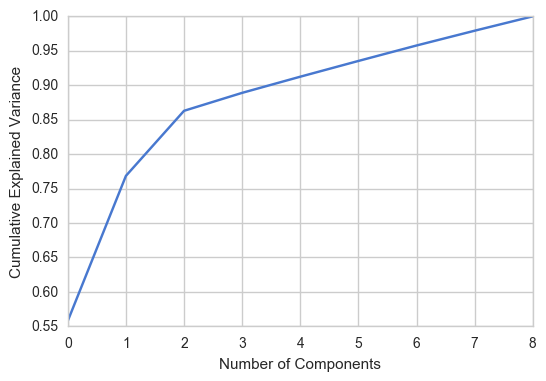

In [9]:
X = df[feature_x]
pca = PCA()
X_reduced = pca.fit_transform(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

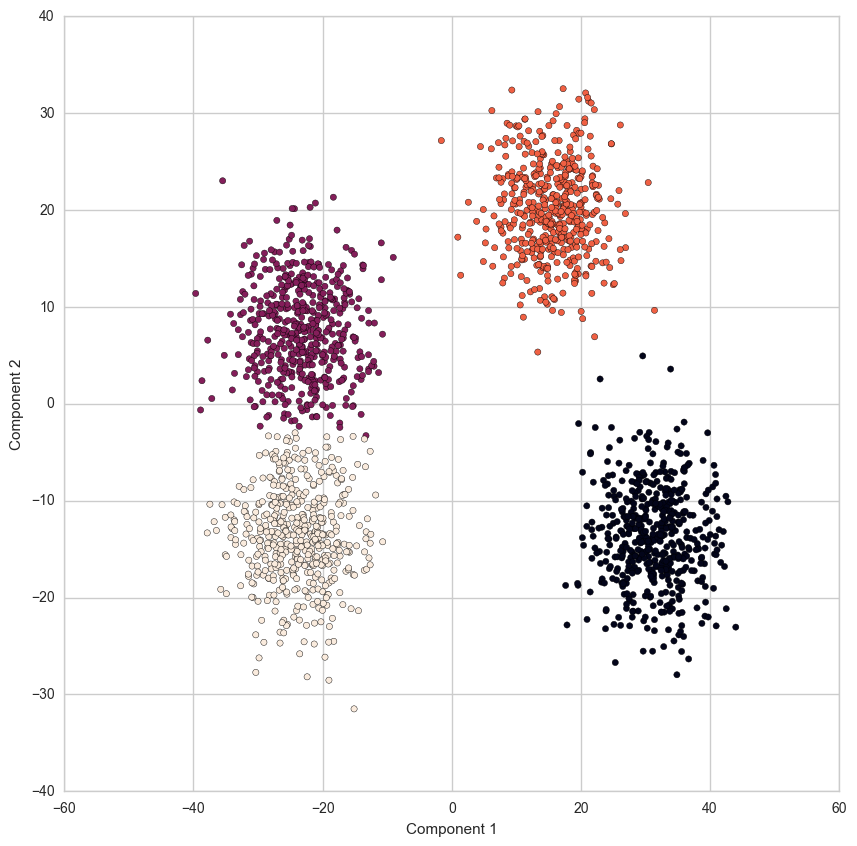

In [12]:
pca = PCA(2)
red = pca.fit_transform(df[feature_x])
y_pred = KMeans(n_clusters=4, random_state=random_state).fit_predict(red)

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(10, 10)

ax.scatter(red[:, 0], red[:, 1], c=y_pred)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
plt.show()

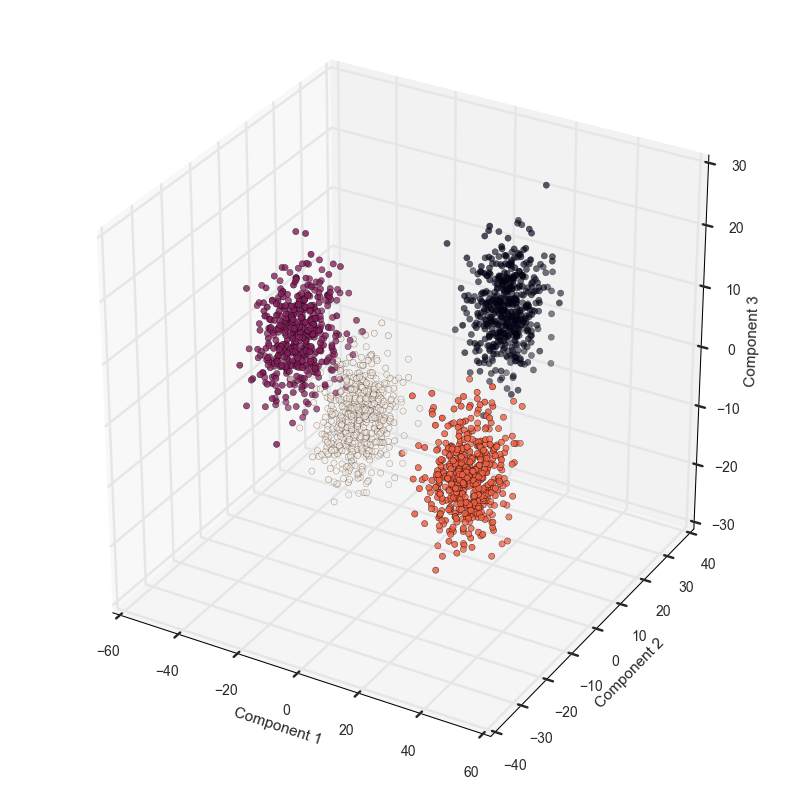

In [15]:
pca = PCA(3)
red = pca.fit_transform(df[feature_x])

y_pred = KMeans(n_clusters=4, random_state=random_state).fit_predict(red)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(10, 10)

ax.scatter(red[:, 0], red[:, 1], red[:, 2], c=y_pred)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.show()